In [1]:
import pandas as pd
df = pd.read_csv("/Users/tiyanigurusinghe/Desktop/FDM Report/proj/Disease_Risk_Prediction_from_Daily_Habits/training/dataset/data.csv")   # adjust filename if different
print(df.shape)
df.head()

(100000, 48)


,survey_code,age,gender,height,weight,bmi,bmi_estimated,bmi_scaled,bmi_corrected,waist_size,...,sunlight_exposure,meals_per_day,caffeine_intake,family_history,pet_owner,electrolyte_level,gene_marker_flag,environmental_risk_score,daily_supplement_dosage,target
0,1,56,Male,173.416872,56.886640,18.915925,18.915925,56.747776,18.989117,72.165130,...,High,5,Moderate,No,Yes,0,1.0,5.5,-2.275502,healthy
1,2,69,Female,163.207380,97.799859,36.716278,36.716278,110.148833,36.511417,85.598889,...,High,5,High,Yes,No,0,1.0,5.5,6.239340,healthy
2,3,46,Male,177.281966,80.687562,25.673050,25.673050,77.019151,25.587429,90.295030,...,High,4,Moderate,No,No,0,1.0,5.5,5.423737,healthy
3,4,32,Female,172.101255,63.142868,21.318480,21.318480,63.955440,21.177109,100.504211,...,High,1,NaN,No,Yes,0,1.0,5.5,8.388611,healthy
4,5,60,Female,163.608816,40.000000,14.943302,14.943302,44.829907,14.844299,69.021150,...,High,1,High,Yes,Yes,0,1.0,5.5,0.332622,healthy


## Missing Values and Duplicate Values

In [2]:
# --- 2) Missingness + Duplicates
na = (
    df.isna()
      .sum()
      .to_frame("n_missing")
      .assign(pct=lambda x: (100 * x["n_missing"] / len(df)).round(2))
      .sort_values(["pct", "n_missing"], ascending=False)
)
print("Duplicates (full-row):", df.duplicated().sum())
print("\nTop-20 missingness:")
display(na.head(20))

Duplicates (full-row): 0

Top-20 missingness:


,n_missing,pct
alcohol_consumption,42387,42.39
caffeine_intake,33261,33.26
exercise_type,24969,24.97
insulin,15836,15.84
heart_rate,14003,14.00
gene_marker_flag,10474,10.47
income,8470,8.47
daily_steps,8329,8.33
blood_pressure,7669,7.67
survey_code,0,0.00


In [3]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

# Define groups of columns
critical_cols = ["insulin", "heart_rate", "blood_pressure"]
simple_num_cols = ["daily_steps", "income"]
cat_cols = ["gene_marker_flag"]

df_copy = df.copy()  # keep original safe

# Use IterativeImputer for multivariate regression
iter_imputer = IterativeImputer(max_iter=10, random_state=42)

df_copy[critical_cols] = iter_imputer.fit_transform(df_copy[critical_cols])

# Median for daily_steps + income
simple_imputer = SimpleImputer(strategy="median")
df_copy[simple_num_cols] = simple_imputer.fit_transform(df_copy[simple_num_cols])

# Replace NaN with "Not Tested"
df_copy["gene_marker_flag"] = df_copy["gene_marker_flag"].fillna("Not Tested")

# Keep track of which values were originally missing
for col in critical_cols + simple_num_cols:
    df_copy[col + "_missing"] = df[col].isna().astype(int)

In [6]:
print(df_copy[critical_cols + simple_num_cols + cat_cols].isna().sum())

insulin             0
heart_rate          0
blood_pressure      0
daily_steps         0
income              0
gene_marker_flag    0
dtype: int64


In [4]:
# --- Handle caffeine intake ---
df_copy["caffeine_missing"] = df_copy["caffeine_intake"].isna().astype(int)
df_copy["caffeine_intake"] = df_copy["caffeine_intake"].fillna("Unknown")

# --- Handle exercise type ---
df_copy["exercise_type"] = df_copy["exercise_type"].fillna("Unknown")

df_copy = df_copy.drop(columns=["alcohol_consumption"])

df_copy.head()

,survey_code,age,gender,height,weight,bmi,bmi_estimated,bmi_scaled,bmi_corrected,waist_size,...,gene_marker_flag,environmental_risk_score,daily_supplement_dosage,target,insulin_missing,heart_rate_missing,blood_pressure_missing,daily_steps_missing,income_missing,caffeine_missing
0,1,56,Male,173.416872,56.886640,18.915925,18.915925,56.747776,18.989117,72.165130,...,1.0,5.5,-2.275502,healthy,1,0,0,0,0,0
1,2,69,Female,163.207380,97.799859,36.716278,36.716278,110.148833,36.511417,85.598889,...,1.0,5.5,6.239340,healthy,0,0,0,0,0,0
2,3,46,Male,177.281966,80.687562,25.673050,25.673050,77.019151,25.587429,90.295030,...,1.0,5.5,5.423737,healthy,1,0,0,0,0,0
3,4,32,Female,172.101255,63.142868,21.318480,21.318480,63.955440,21.177109,100.504211,...,1.0,5.5,8.388611,healthy,0,0,0,0,0,1
4,5,60,Female,163.608816,40.000000,14.943302,14.943302,44.829907,14.844299,69.021150,...,1.0,5.5,0.332622,healthy,0,0,0,0,0,0


In [5]:
# --- 2) Missingness + Duplicates
na = (
    df_copy.isna()
      .sum()
      .to_frame("n_missing")
      .assign(pct=lambda x: (100 * x["n_missing"] / len(df)).round(2))
      .sort_values(["pct", "n_missing"], ascending=False)
)
print("Duplicates (full-row):", df_copy.duplicated().sum())
print("\nTop-10 missingness:")
display(na.head(10))

Duplicates (full-row): 0

Top-10 missingness:


,n_missing,pct
survey_code,0,0.0
age,0,0.0
gender,0,0.0
height,0,0.0
weight,0,0.0
bmi,0,0.0
bmi_estimated,0,0.0
bmi_scaled,0,0.0
bmi_corrected,0,0.0
waist_size,0,0.0


## Outlier Detection

### Numerical Variables

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

def outlier_summary(df, z_thresh=3):
    """
    Detect outliers in numeric columns using IQR and Z-score methods.
    
    Parameters:
        df : pandas DataFrame
        z_thresh : float, threshold for Z-score (default=3)
    
    Returns:
        summary_df : DataFrame with counts and % of outliers for each method
    """
    
    num_cols = df.select_dtypes(include=[np.number]).columns
    results = []

    for col in num_cols:
        series = df[col].dropna()

        # --- IQR Method ---
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        iqr_outliers = ((series < lower) | (series > upper)).sum()

        # --- Z-score Method ---
        z_scores = zscore(series)
        z_outliers = (np.abs(z_scores) > z_thresh).sum()

        # Save results
        results.append({
            "Feature": col,
            "IQR_outliers": iqr_outliers,
            "IQR_outlier_pct": round(100 * iqr_outliers / len(series), 2),
            "Z_outliers": z_outliers,
            "Z_outlier_pct": round(100 * z_outliers / len(series), 2),
        })

    return pd.DataFrame(results).sort_values("IQR_outlier_pct", ascending=False)

# --- Run on your dataset ---
summary = outlier_summary(df_copy)
print(summary)

print(df_copy.shape)
df_copy.head()
df_2 = df_copy.iloc[:,:47]
df_2.head()
print(df_2.shape)

                     Feature  IQR_outliers  IQR_outlier_pct  Z_outliers  \
29           insulin_missing         15836            15.84           0   
30        heart_rate_missing         14003            14.00           0   
33            income_missing          8470             8.47        8470   
32       daily_steps_missing          8329             8.33        8329   
31    blood_pressure_missing          7669             7.67        7669   
13                   insulin          2788             2.79         456   
10                heart_rate          2450             2.45         473   
9             blood_pressure          1333             1.33         330   
6                 bmi_scaled           936             0.94         447   
7              bmi_corrected           937             0.94         454   
4                        bmi           936             0.94         447   
5              bmi_estimated           936             0.94         447   
2                     hei

/var/folders/0m/8jvlbw_n01q88qtgc5ml8j0r0000gn/T/ipykernel_73146/1231389567.py:31: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = zscore(series)


In [7]:
def remove_small_outliers(df, summary, pct_thresh):
    """
    Removes outliers for features where IQR_outlier_pct < pct_thresh
    (only for columns that exist in df and are numeric).
    """
    cleaned_df = df.copy()
    
    # Get candidate features
    num_cols = summary[summary["IQR_outlier_pct"] < pct_thresh]["Feature"].tolist()
    # Keep only those present in df
    num_cols = [c for c in num_cols if c in cleaned_df.columns and pd.api.types.is_numeric_dtype(cleaned_df[c])]

    for col in num_cols:
        series = cleaned_df[col].dropna()
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        # keep only rows inside limits
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]
    
    return cleaned_df

# --- Apply ---
df_3 = remove_small_outliers(df_2, summary, pct_thresh=2.0)

print("Original rows:", df_2.shape)
print("Cleaned rows :", df_3.shape)

Original rows: (100000, 47)
Cleaned rows : (90290, 47)


### Categorical Variables


=== gender — 2 categories ===
        count    pct
gender              
Male    45285  50.16
Female  45005  49.84


/var/folders/0m/8jvlbw_n01q88qtgc5ml8j0r0000gn/T/ipykernel_72260/582658453.py:22: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(treat_nan_as)


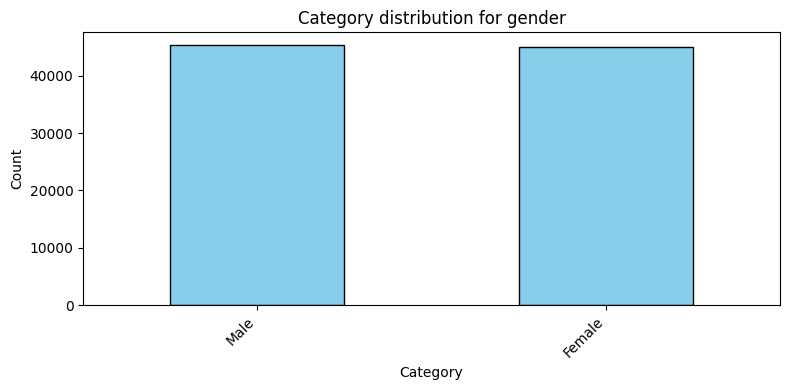

[skip] marital_status not in dataframe.

=== diet_type — 4 categories ===
            count    pct
diet_type               
Omnivore    22703  25.14
Vegan       22680  25.12
Vegetarian  22578  25.01
Keto        22329  24.73


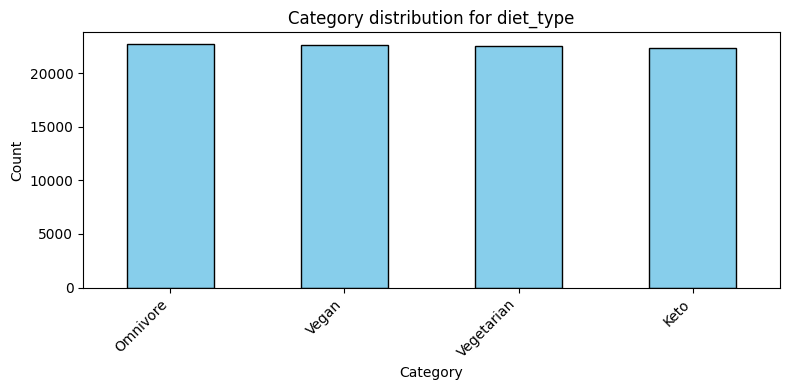


=== occupation — 6 categories ===
            count    pct
occupation              
Doctor      15274  16.92
Farmer      15086  16.71
Teacher     15063  16.68
Artist      15009  16.62
Driver      14951  16.56
Engineer    14907  16.51


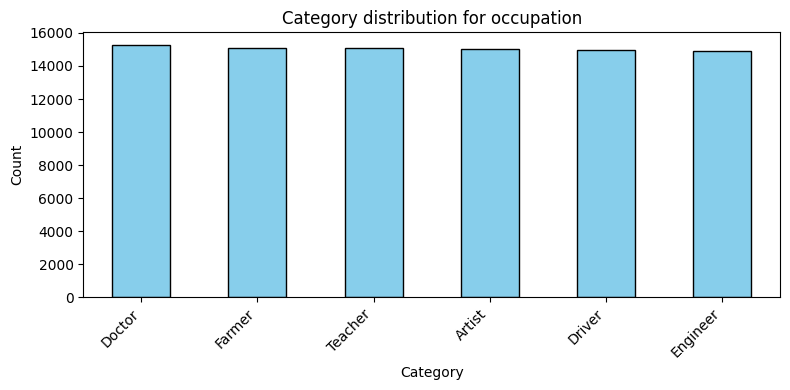


=== sleep_quality — 4 categories ===
               count    pct
sleep_quality              
Excellent      22702  25.14
Good           22635  25.07
Fair           22584  25.01
Poor           22369  24.77


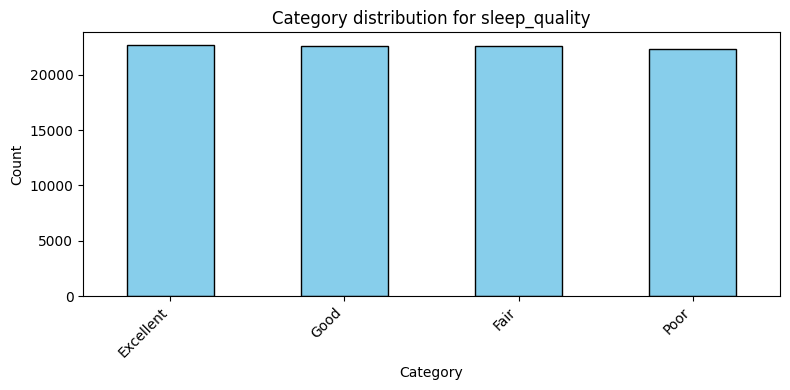


=== mental_health_support — 2 categories ===
                       count    pct
mental_health_support              
No                     45194  50.05
Yes                    45096  49.95


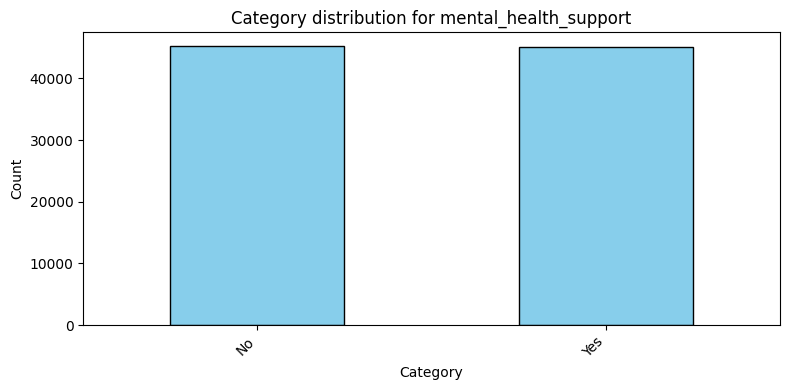


=== exercise_type — 4 categories ===
               count    pct
exercise_type              
Strength       22815  25.27
Cardio         22611  25.04
Unknown        22500  24.92
Mixed          22364  24.77


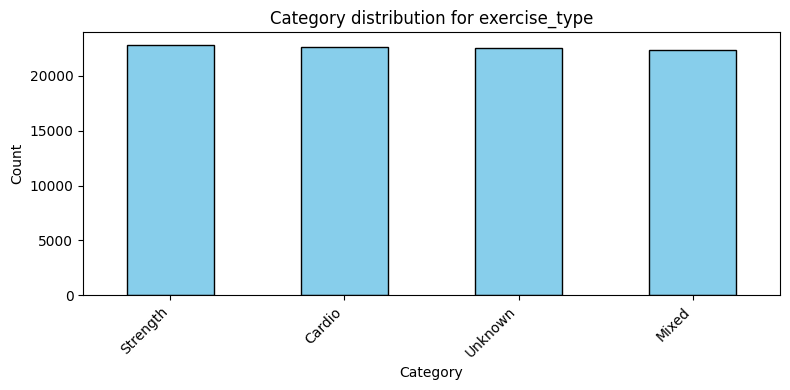


=== device_usage — 3 categories ===
              count    pct
device_usage              
High          30263  33.52
Low           30039  33.27
Moderate      29988  33.21


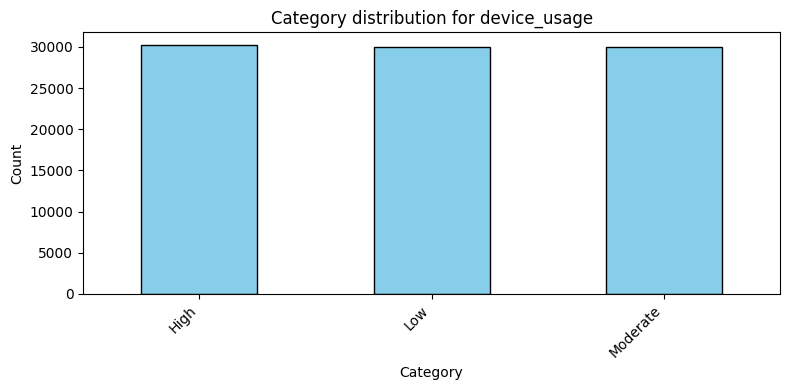


=== healthcare_access — 3 categories ===
                   count    pct
healthcare_access              
Poor               30129  33.37
Good               30120  33.36
Moderate           30041  33.27


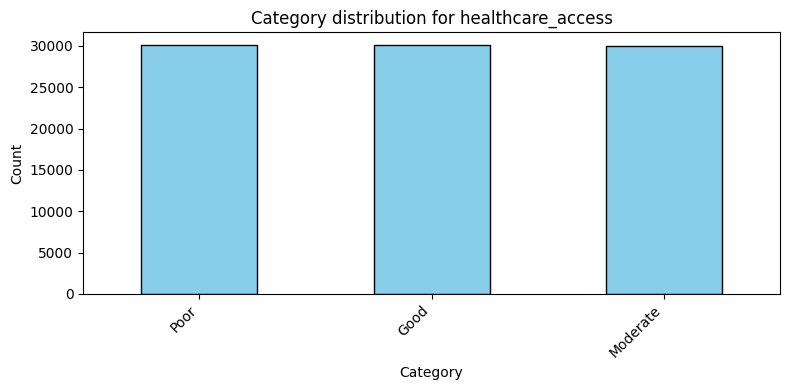


=== insurance — 2 categories ===
           count    pct
insurance              
Yes        45282  50.15
No         45008  49.85


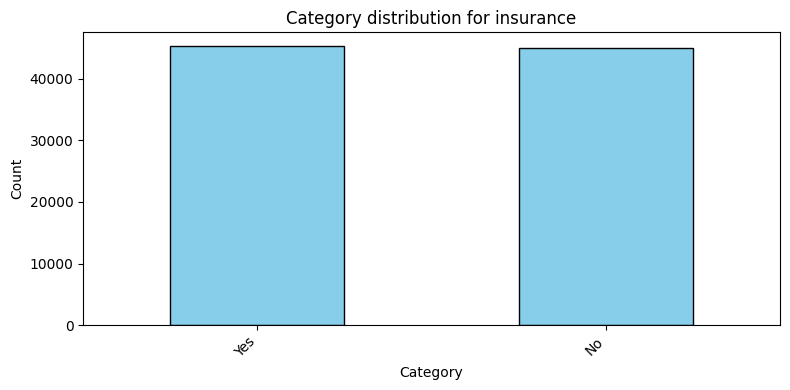


=== family_history — 2 categories ===
                count    pct
family_history              
Yes             45183  50.04
No              45107  49.96


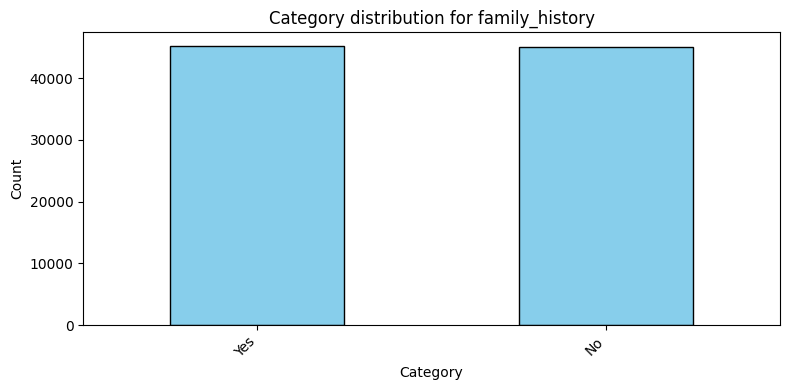


=== sunlight_exposure — 3 categories ===
                   count    pct
sunlight_exposure              
Low                30205  33.45
Moderate           30113  33.35
High               29972  33.20


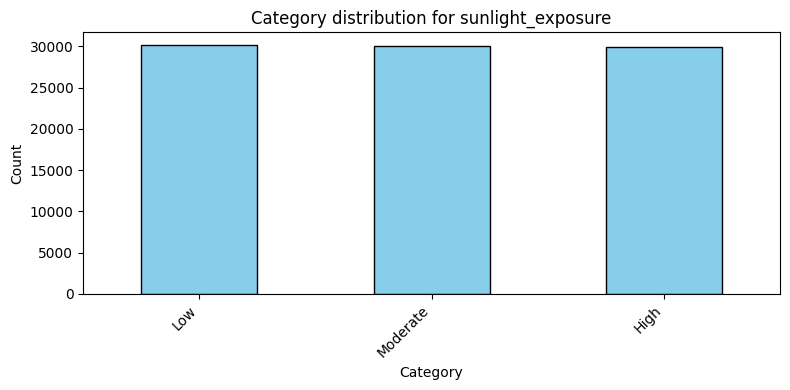


=== pet_owner — 2 categories ===
           count    pct
pet_owner              
No         45371  50.25
Yes        44919  49.75


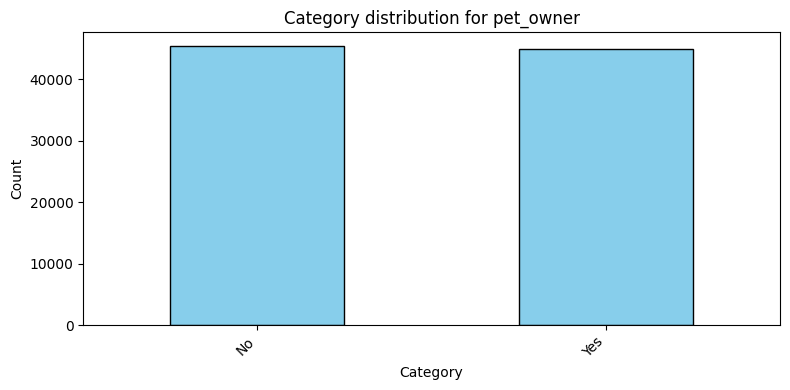


=== caffeine_intake — 3 categories ===
                 count    pct
caffeine_intake              
High             30172  33.42
Moderate         30095  33.33
Unknown          30023  33.25


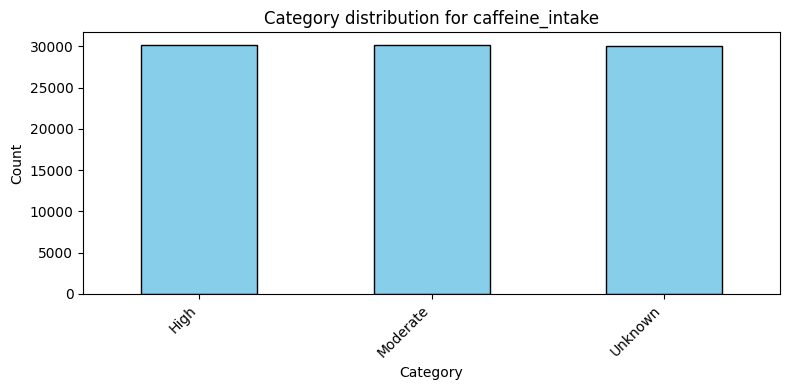


=== meals_per_day — 5 categories ===
               count    pct
meals_per_day              
3              18129  20.08
1              18111  20.06
5              18039  19.98
2              18008  19.94
4              18003  19.94


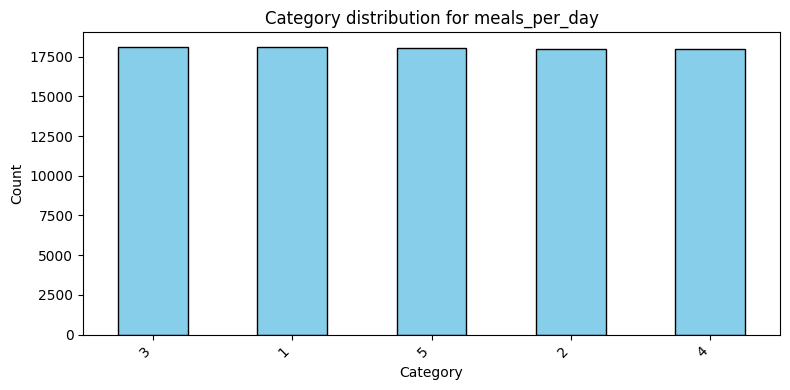



=== LOW-FREQUENCY CATEGORIES (<1%) ACROSS ALL COLUMNS ===


,feature,category,count,pct


In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def categorical_low_freq_report(
    df: pd.DataFrame,
    cat_cols: list,
    min_pct: float = 1.0,        # threshold in %
    treat_nan_as: str = "Unknown" # set to None to ignore NaN
):
    """
    For each categorical column:
      - shows all categories with counts and %
      - plots a bar chart of category frequencies
      - returns one tidy DataFrame with only categories below min_pct
    """
    df_work = df.copy()
    if treat_nan_as is not None:
        for c in cat_cols:
            if c in df_work.columns:
                df_work[c] = (
                    df_work[c].astype("object")
                    .fillna(treat_nan_as)
                    .astype(str)
                    .str.strip()
                )

    all_tables = {}
    lows = []

    for c in cat_cols:
        if c not in df_work.columns:
            print(f"[skip] {c} not in dataframe.")
            continue

        vc = df_work[c].value_counts(dropna=False)
        pct = (vc / len(df_work) * 100).round(2)
        table = pd.DataFrame({"count": vc, "pct": pct})
        all_tables[c] = table

        # collect low-frequency rows
        low_rows = table[table["pct"] < min_pct].copy()
        if not low_rows.empty:
            low_rows.insert(0, "feature", c)
            low_rows = low_rows.reset_index().rename(columns={"index": "category"})
            lows.append(low_rows)

        # quick peek per column
        print(f"\n=== {c} — {len(table)} categories ===")
        print(table.head(10))

        # --- bar chart ---
        plt.figure(figsize=(8, 4))
        vc.plot(kind="bar", color="skyblue", edgecolor="black")
        plt.title(f"Category distribution for {c}")
        plt.xlabel("Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    low_freq_df = (
        pd.concat(lows, ignore_index=True)
        if lows
        else pd.DataFrame(columns=["feature", "category", "count", "pct"])
    )
    return all_tables, low_freq_df

# ---- your categorical columns ----
cat_cols = [
    "gender","marital_status","diet_type","occupation","sleep_quality",
    "mental_health_support","exercise_type","device_usage","healthcare_access",
    "insurance","family_history","sunlight_exposure","pet_owner",
    "caffeine_intake","meals_per_day"
]

# ---- run it ----
all_freqs, low_freq = categorical_low_freq_report(
    df_3, cat_cols, min_pct=1.0, treat_nan_as="Unknown"
)

print("\n\n=== LOW-FREQUENCY CATEGORIES (<1%) ACROSS ALL COLUMNS ===")
display(low_freq.sort_values(["feature","pct"]))

## Encoding

In [8]:
from sklearn.preprocessing import LabelEncoder

# ---- Binary & Ordinal Columns ----
binary_cols = ["gender", "insurance", "pet_owner", "family_history", "mental_health_support"]
ordinal_cols = ["sleep_quality", "device_usage", "sunlight_exposure", "healthcare_access", "caffeine_intake", "device_usage"]

# Initialize LabelEncoder
le = LabelEncoder()

# Encode binary columns
for col in binary_cols:
    if col in df_3.columns:
        df_3[col] = le.fit_transform(df_3[col].astype(str))

# Encode ordinal columns
for col in ordinal_cols:
    if col in df_3.columns:
        df_3[col] = le.fit_transform(df_3[col].astype(str))

In [9]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd


nominal_cols = ["diet_type","occupation","exercise_type","meals_per_day"]

encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")

encoded_nom = pd.DataFrame(
    encoder.fit_transform(df_3[nominal_cols]),
    columns=encoder.get_feature_names_out(nominal_cols),
    index=df_3.index
)

# Drop original & add encoded
df_3 = df_3.drop(columns=nominal_cols).join(encoded_nom)

## EDA

### Numerical Varaibles

Analyzing 28 numeric columns...


/var/folders/0m/8jvlbw_n01q88qtgc5ml8j0r0000gn/T/ipykernel_72260/654293076.py:51: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "skew": skew(s),
/var/folders/0m/8jvlbw_n01q88qtgc5ml8j0r0000gn/T/ipykernel_72260/654293076.py:51: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  "skew": skew(s),


,feature,count,missing_pct,mean,std,min,q1,median,q3,max,skew,iqr_outlier_pct
12,insulin,90290,0.00,14.985906,4.590312,-6.794483,12.312922,14.988289,17.664984,34.418460,0.000901,2.73
9,heart_rate,90290,0.00,74.972746,9.224429,34.745092,69.530000,74.969356,80.490824,114.136041,-0.021378,2.41
8,blood_pressure,90290,0.00,119.987118,13.694244,83.273617,110.978718,119.980151,129.042950,156.736217,-0.001830,0.18
16,daily_steps,90290,0.00,6962.088823,2320.056244,1000.000000,5484.569434,7004.285450,8479.283411,13056.822939,-0.072462,0.08
18,sugar_intake,90290,0.00,60.091405,19.390381,6.213763,46.670519,60.063923,73.392580,113.909670,0.013256,0.06
23,income,90290,0.00,3994.314758,1793.995375,500.000000,2782.894018,4004.601345,5181.539479,8840.466558,0.081932,0.06
1,height,90290,0.00,170.163949,9.579733,143.566943,163.545098,170.113363,176.738247,196.773246,0.023906,0.05
7,waist_size,90290,0.00,84.949875,11.684375,52.486583,76.895605,84.981087,92.969823,117.354365,-0.003842,0.05
10,cholesterol,90290,0.00,189.989386,29.121898,108.772444,169.808975,190.047636,210.070267,271.084540,-0.002805,0.05
17,calorie_intake,90290,0.00,2202.111693,388.048644,1124.789013,1935.338269,2201.802241,2469.114380,3279.097513,0.000308,0.05


/var/folders/0m/8jvlbw_n01q88qtgc5ml8j0r0000gn/T/ipykernel_72260/654293076.py:69: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  if (s.min() > 0) and (skew(s) > 1.0):



🔎 Consider log-transform for (skew > 1 and values > 0):
None flagged


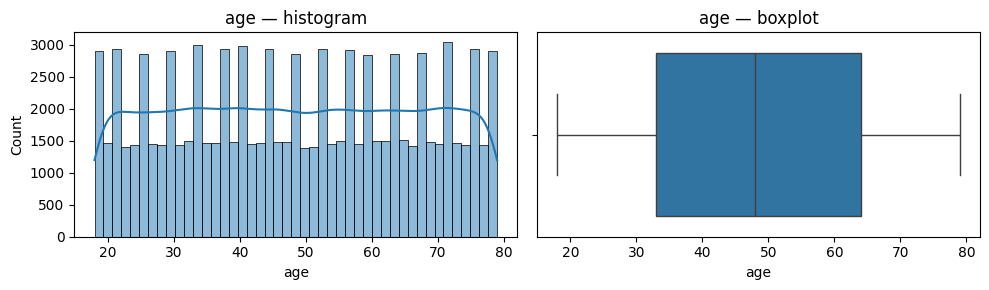

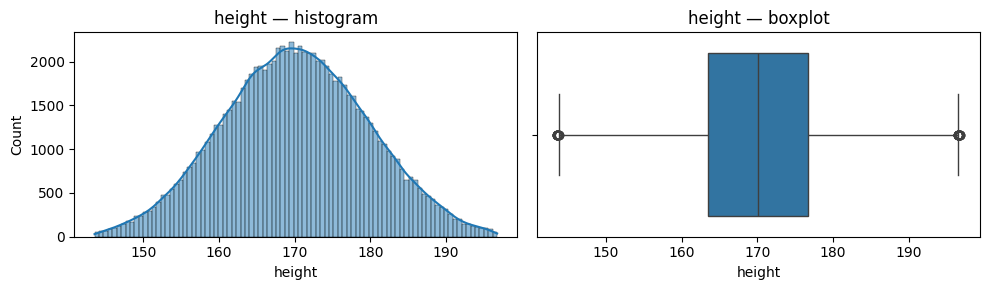

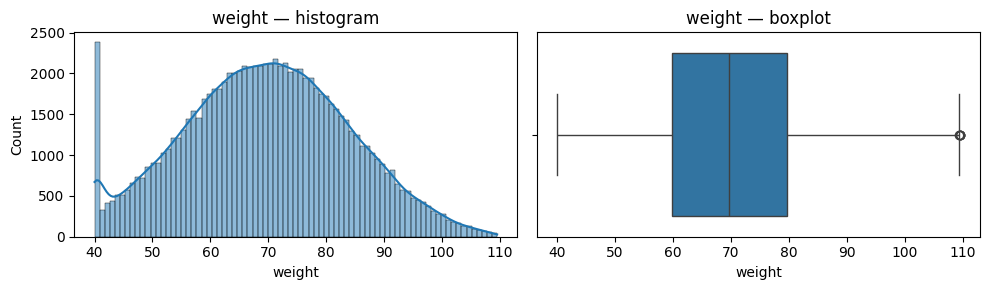

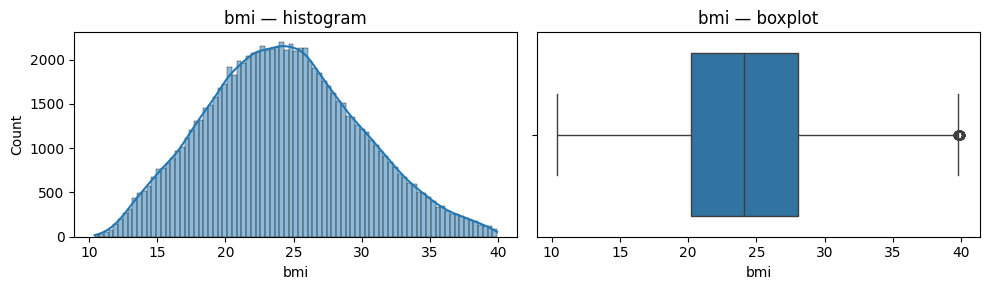

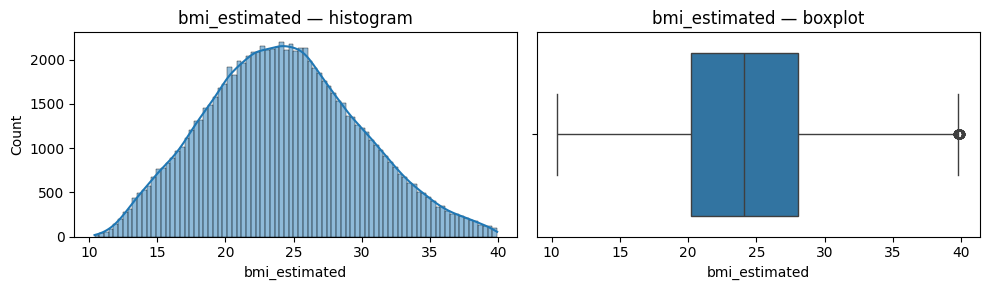

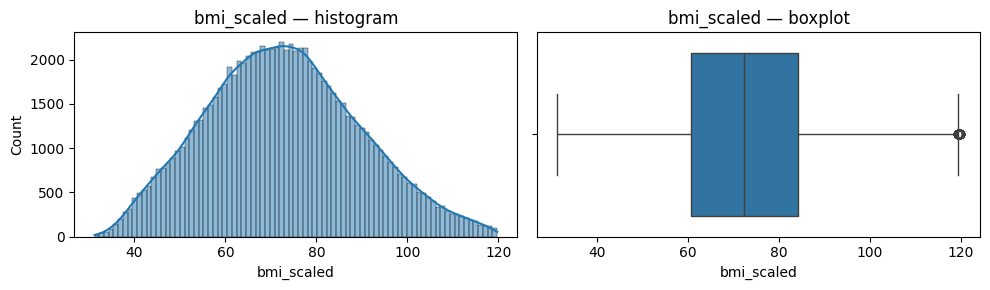

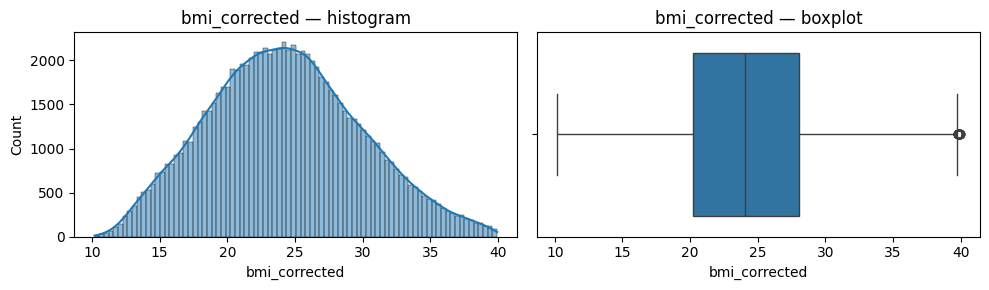

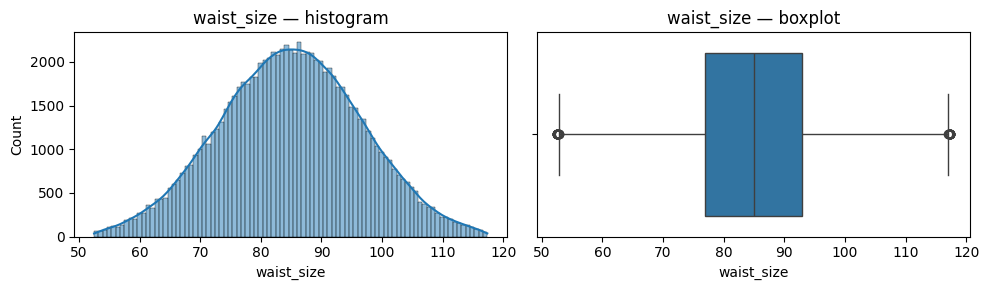

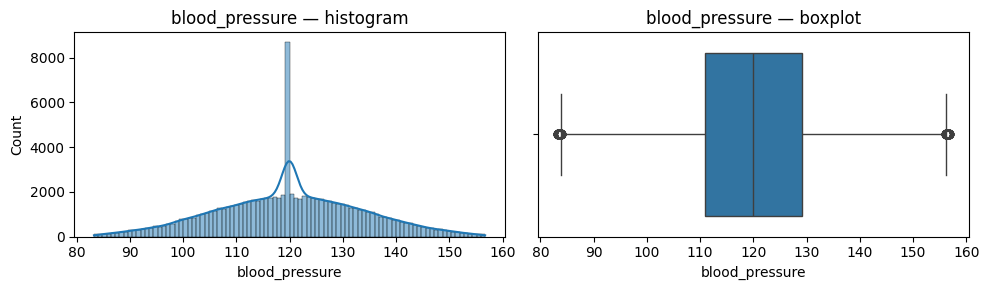

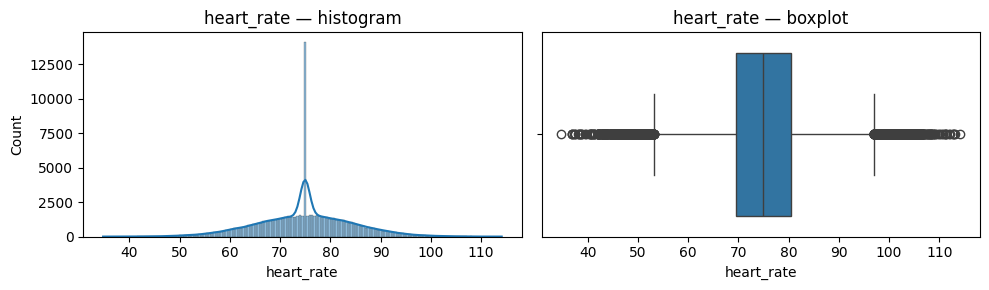

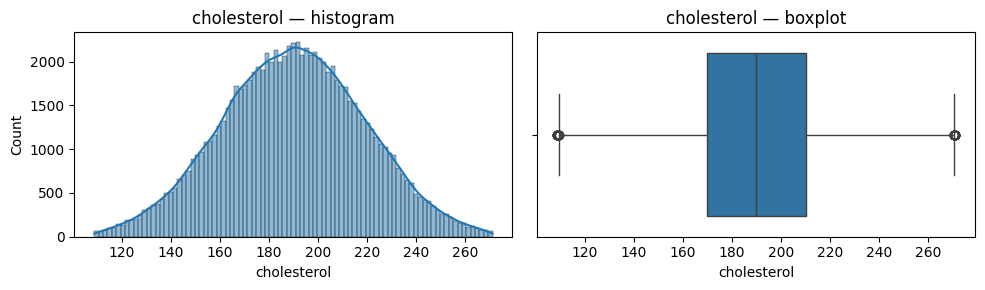

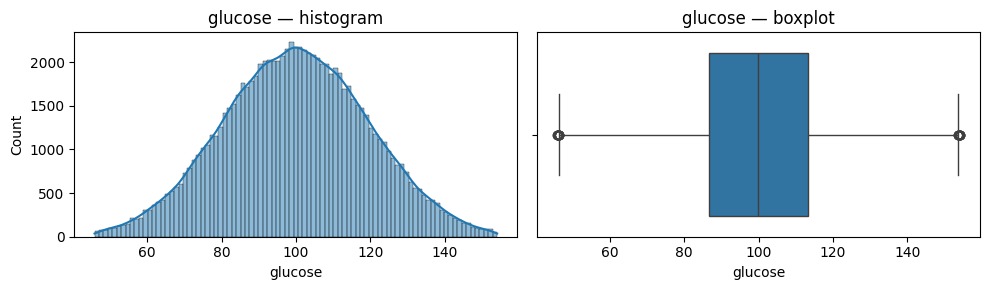

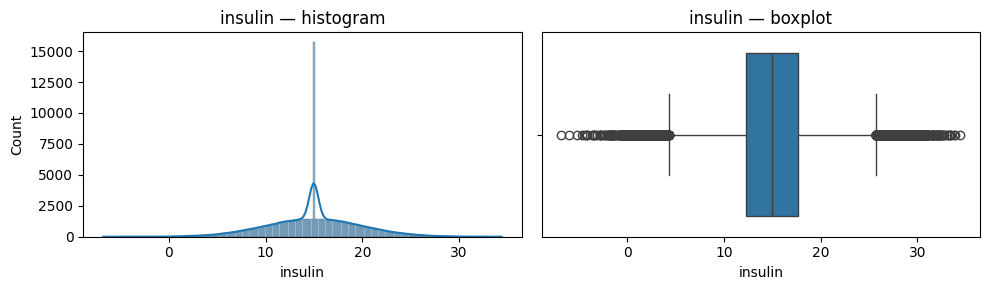

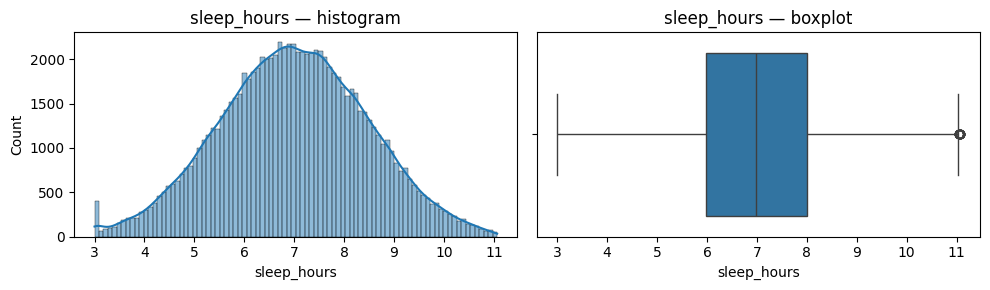

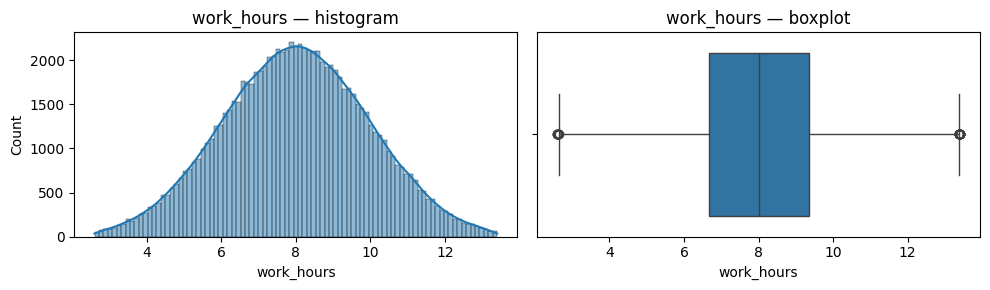

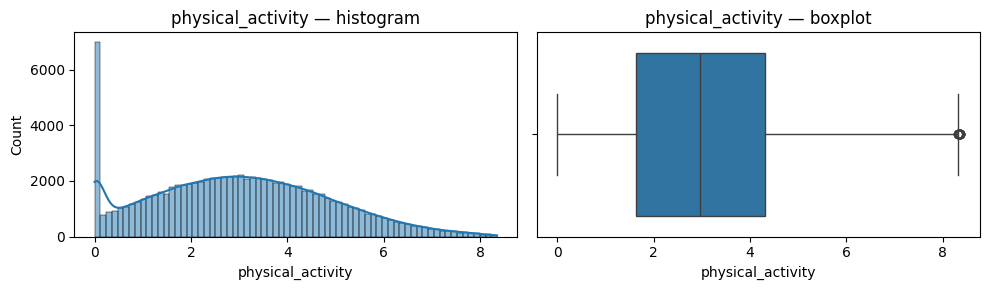

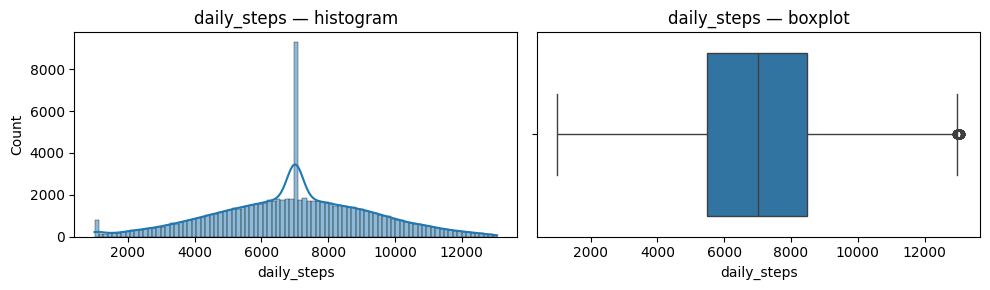

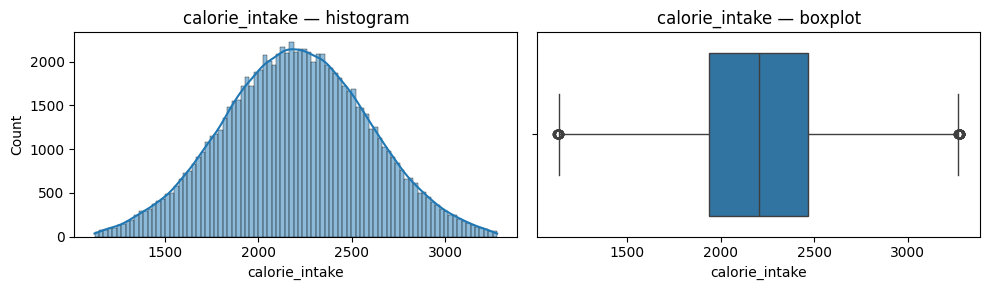

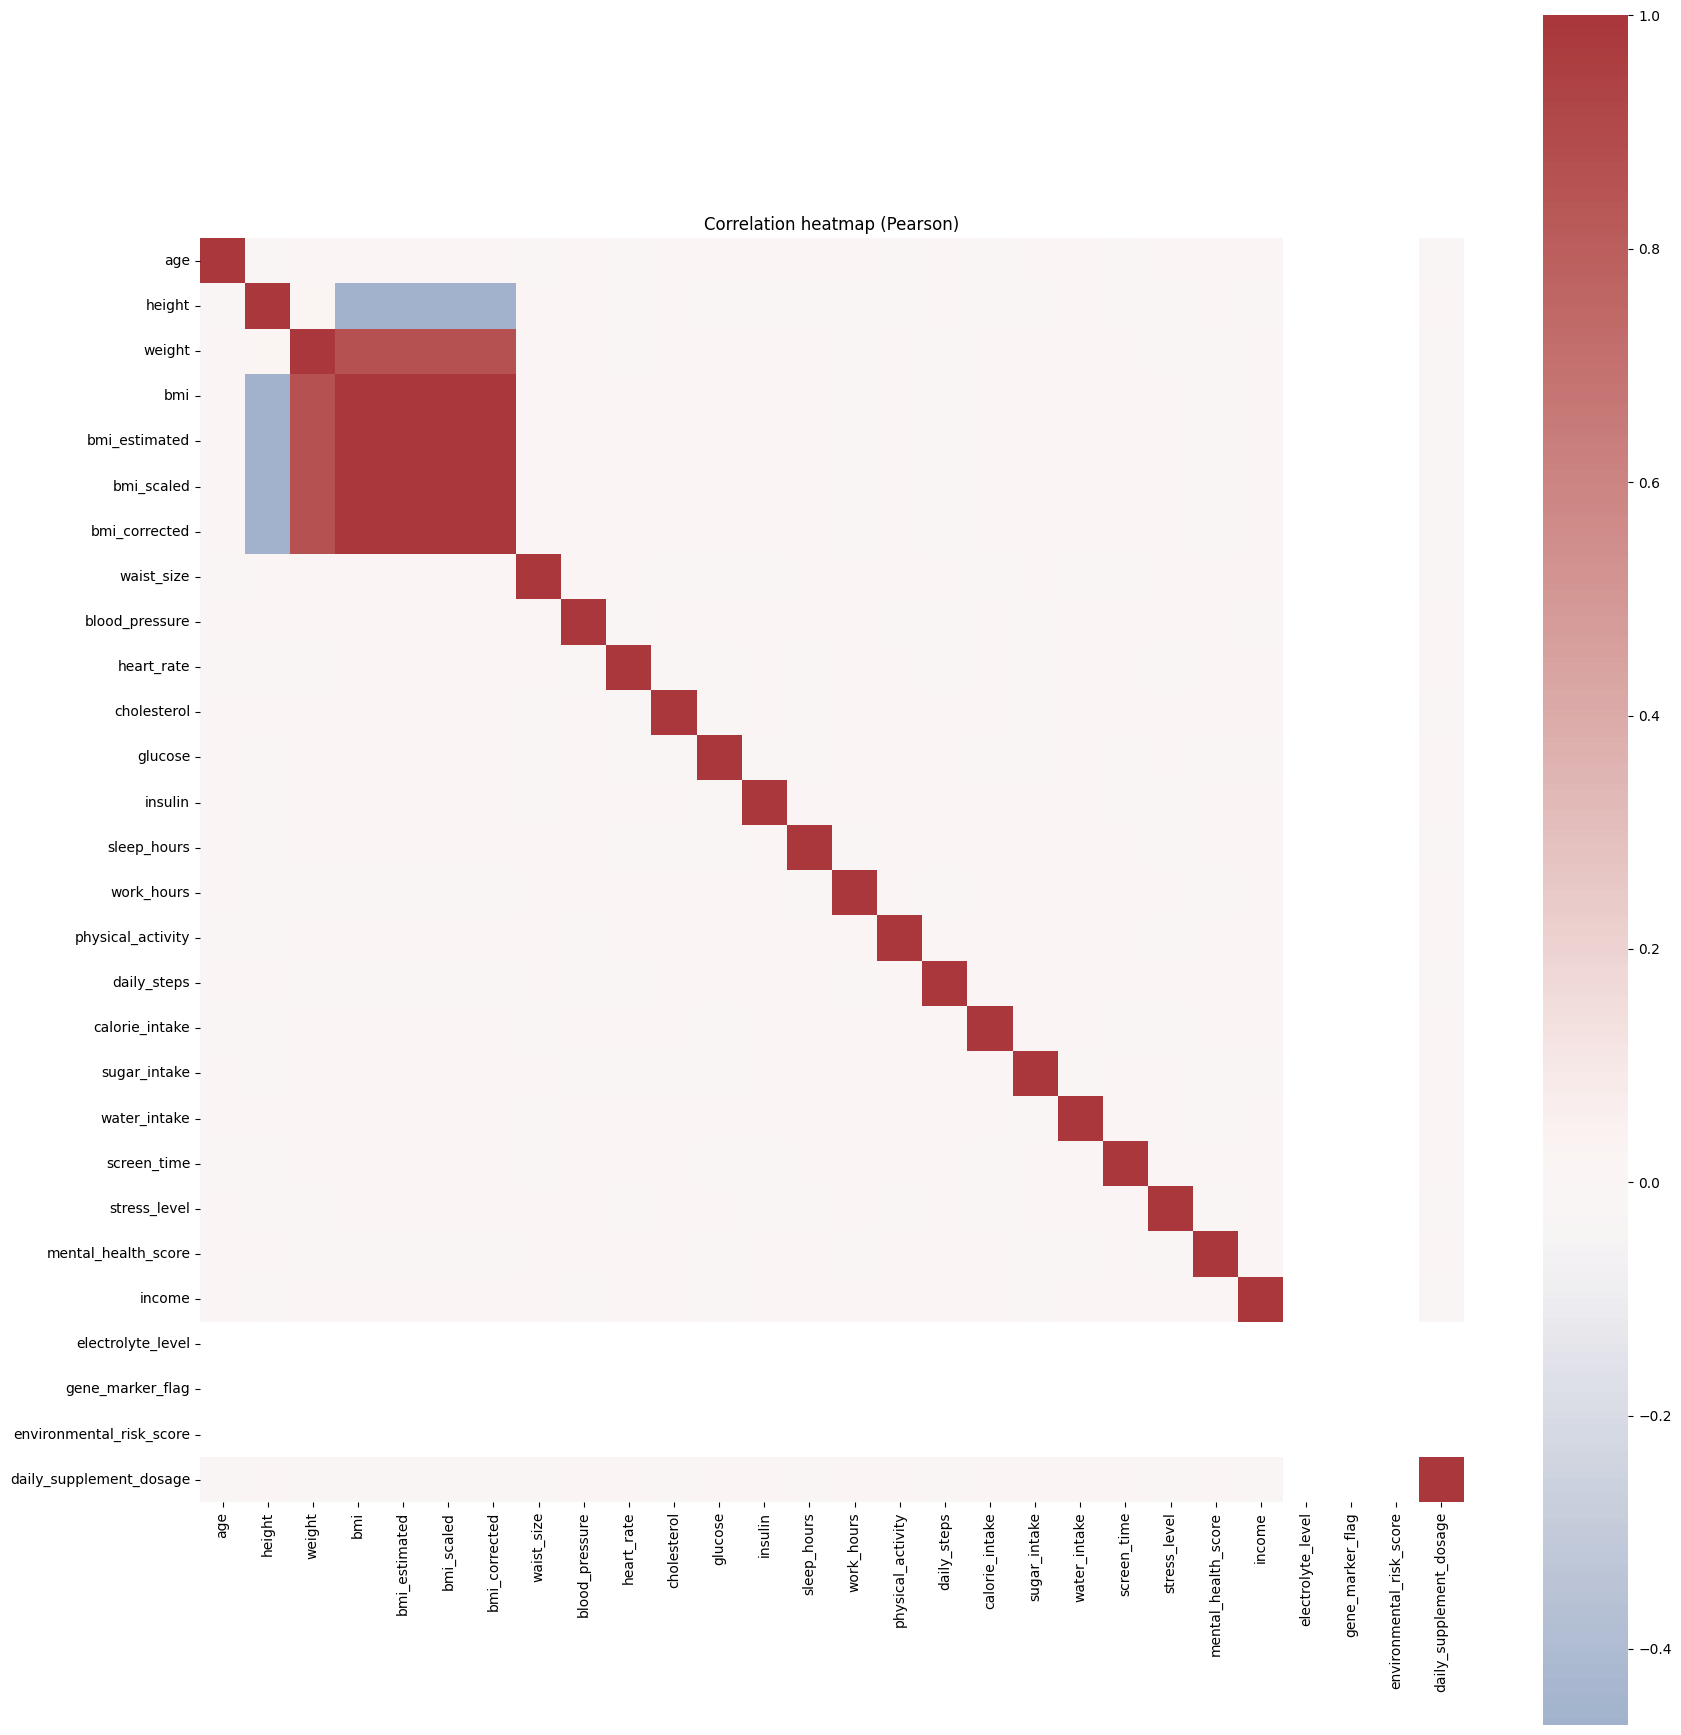

In [19]:
# ==========================
# NUMERIC EDA for given cols
# ==========================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, pearsonr

DF = df_3                      # <- your dataframe
TARGET_COL = None              # e.g., "Health_Status" (binary). Or None to skip target analysis.
SUBSAMPLE = 20000              # for heavy plots
RANDOM_STATE = 42

numeric_cols_requested = [
    'age','height','weight','bmi','bmi_estimated','bmi_scaled','bmi_corrected','waist_size',
    'blood_pressure','heart_rate','cholesterol','glucose','insulin','sleep_hours','work_hours',
    'physical_activity','daily_steps','calorie_intake','sugar_intake','water_intake','screen_time',
    'stress_level','mental_health_score','income','meals_per_day','electrolyte_level',
    'gene_marker_flag','environmental_risk_score','daily_supplement_dosage'
]
num_cols = [c for c in numeric_cols_requested if c in DF.columns]

def to_num(s):
    return pd.to_numeric(s, errors="coerce")

def iqr_bounds(s):
    s = to_num(s).dropna()
    if s.empty: return (np.nan, np.nan)
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

def numeric_summary(df, cols):
    rows = []
    n = len(df)
    for c in cols:
        s = to_num(df[c]).dropna()
        if s.empty: 
            rows.append({"feature": c, "count": 0, "missing_pct": 100.0})
            continue
        lb, ub = iqr_bounds(s)
        out_pct = np.round(100 * ((s < lb) | (s > ub)).mean(), 2) if not np.isnan(lb) else np.nan
        rows.append({
            "feature": c,
            "count": len(s),
            "missing_pct": np.round(100*(1 - len(s)/n), 2),
            "mean": s.mean(), "std": s.std(),
            "min": s.min(), "q1": s.quantile(0.25), "median": s.median(),
            "q3": s.quantile(0.75), "max": s.max(),
            "skew": skew(s),
            "iqr_outlier_pct": out_pct
        })
    out = pd.DataFrame(rows)
    if not out.empty:
        out = out.sort_values(["iqr_outlier_pct","missing_pct"], ascending=False, na_position="last")
    return out

# --- 1) Summary table
print(f"Analyzing {len(num_cols)} numeric columns...")
num_sum = numeric_summary(DF, num_cols)
display(num_sum)

# --- 2) Log-transform suggestions (right-skewed & positive)
suggest_log = []
for c in num_cols:
    s = to_num(DF[c]).dropna()
    if s.empty: continue
    if (s.min() > 0) and (skew(s) > 1.0):
        suggest_log.append(c)
print("\n🔎 Consider log-transform for (skew > 1 and values > 0):")
print(suggest_log if suggest_log else "None flagged")

# --- 3) Histograms + boxplots
to_plot = num_cols if len(num_cols) <= 18 else num_cols[:18]   # keep it readable
for c in to_plot:
    s = to_num(DF[c])
    fig, ax = plt.subplots(1, 2, figsize=(10,3))
    sns.histplot(s, kde=True, ax=ax[0])
    ax[0].set_title(f"{c} — histogram")
    sns.boxplot(x=s, ax=ax[1])
    ax[1].set_title(f"{c} — boxplot")
    plt.tight_layout(); plt.show()

# --- 4) Correlation heatmap (numeric cols only)
num_df = DF[num_cols].apply(to_num)
corr = num_df.corr(method="pearson")
plt.figure(figsize=(min(1.1*len(num_cols), 18), min(1.1*len(num_cols), 18)))
sns.heatmap(corr, cmap="vlag", center=0, square=True, cbar=True)
plt.title("Correlation heatmap (Pearson)"); plt.tight_layout(); plt.show()

# --- 5) Relationship with target (optional)
if TARGET_COL and TARGET_COL in DF.columns:
    # Build numeric 0/1 target
    y_raw = DF[TARGET_COL]
    y_num = pd.to_numeric(y_raw, errors="coerce")
    if y_num.nunique(dropna=True) != 2:
        # factorize to 0/1
        codes, _ = pd.factorize(y_raw.astype(str))
        y_num = pd.Series(codes, index=DF.index)

    # Boxplots by target + point-biserial correlation
    for c in num_cols:
        x = to_num(DF[c])
        if x.notna().sum() == 0: 
            continue
        try:
            r, p = pearsonr(x.fillna(x.median()), y_num.fillna(y_num.mode()[0]))
            print(f"{c}: point-biserial r={r:.3f} (p={p:.3g})")
        except Exception:
            pass
        plt.figure(figsize=(6,3))
        sns.boxplot(x=y_num, y=x)
        plt.title(f"{c} by {TARGET_COL}")
        plt.xlabel(TARGET_COL); plt.ylabel(c)
        plt.tight_layout(); plt.show()

In [11]:
# Drop unnecessary columns
drop_cols = ["gene_marker_flag", "environmental_risk_score", "electrolyte_level", "heart_rate", "insulin"]

df_4 = df_3.drop(columns=drop_cols, errors="ignore")

print("Remaining columns:", df_4.shape[1])

Remaining columns: 53


In [30]:
df_4.head()

drop_cols = ["bmi_estimated", "bmi_scaled","bmi_corrected", "waist_size", "sugar_intake", "mental_health_score","income", "device_usage", "survey_code"]

df_4 = df_4.drop(columns=drop_cols, errors="ignore")

print("Remaining columns:", df_4.shape[1])
df_4.head()
print(df_4.columns)

Remaining columns: 44
Index(['age', 'gender', 'height', 'weight', 'bmi', 'blood_pressure',
       'cholesterol', 'glucose', 'sleep_hours', 'sleep_quality', 'work_hours',
       'physical_activity', 'daily_steps', 'calorie_intake', 'smoking_level',
       'water_intake', 'screen_time', 'stress_level', 'mental_health_support',
       'education_level', 'job_type', 'healthcare_access', 'insurance',
       'sunlight_exposure', 'caffeine_intake', 'family_history', 'pet_owner',
       'daily_supplement_dosage', 'target', 'diet_type_Omnivore',
       'diet_type_Vegan', 'diet_type_Vegetarian', 'occupation_Doctor',
       'occupation_Driver', 'occupation_Engineer', 'occupation_Farmer',
       'occupation_Teacher', 'exercise_type_Mixed', 'exercise_type_Strength',
       'exercise_type_Unknown', 'meals_per_day_2', 'meals_per_day_3',
       'meals_per_day_4', 'meals_per_day_5'],
      dtype='object')


## Model

### Without SMOTE Models

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# -----------------------
# 1) Prepare X, y
# -----------------------
df5 = df_4.copy()

# detect/encode target to 0/1 if needed
y_raw = df5["target"]
if y_raw.dtype.kind in "iu":
    y = y_raw.values
else:
    # try common mapping then fallback to factorize
    mapping = {"healthy":0, "Healthy":0, "at risk":1, "At Risk":1, "diseased":1, "Disease":1}
    y_tmp = y_raw.map(mapping)
    if y_tmp.isna().any():
        y_tmp, _ = pd.factorize(y_raw.astype(str))  # 0/1 by frequency
    y = y_tmp.values

X = df5.drop(columns=["target"])

# auto-detect numeric vs categorical
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]  # objects/strings, etc.

print(f"Numerical: {len(num_cols)}  |  Categorical: {len(cat_cols)}")

# class imbalance helper for XGB/LGBM
pos = (y==1).sum()
neg = (y==0).sum()
scale_pos_weight = neg / max(pos, 1)

# -----------------------
# 2) Preprocessor
# -----------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)

# -----------------------
# 3) Models
# -----------------------
models = [
    ("LogisticRegression", LogisticRegression(max_iter=1000, class_weight="balanced")),
    ("RandomForest",      RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)),
    ("XGBoost",           XGBClassifier(
                             n_estimators=500, learning_rate=0.05, max_depth=6,
                             subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
                             scale_pos_weight=scale_pos_weight, eval_metric="logloss",
                             random_state=42, n_jobs=-1)),
    ("LightGBM",          LGBMClassifier(
                             n_estimators=800, learning_rate=0.03, num_leaves=63,
                             subsample=0.9, colsample_bytree=0.9,
                             class_weight=None,  # uses scale_pos_weight internally if needed
                             random_state=42)),
    ("CatBoost",          CatBoostClassifier(
                             iterations=700, depth=6, learning_rate=0.05,
                             loss_function="Logloss", verbose=0, random_state=42))
]

# -----------------------
# 4) Train/test split
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------
# 5) Fit & evaluate
# -----------------------
results = []

for name, est in models:
    pipe = Pipeline([("prep", preprocessor), ("clf", est)])

    pipe.fit(X_train, y_train)

    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    auc  = roc_auc_score(y_test, y_proba)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC-AUC:", round(auc, 4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    results.append((name, auc, pipe))

# ranked leaderboard
leaderboard = pd.DataFrame(results, columns=["Model","ROC_AUC","Pipeline"]).sort_values("ROC_AUC", ascending=False)
print("\n=== Leaderboard (by ROC-AUC) ===")
print(leaderboard[["Model","ROC_AUC"]])
best_name = leaderboard.iloc[0]["Model"]
print(f"\nBest model: {best_name}")
best_pipeline = leaderboard.iloc[0]["Pipeline"]

Numerical: 40  |  Categorical: 3

=== RandomForest ===
              precision    recall  f1-score   support

           0      0.701     1.000     0.824     12656
           1      0.000     0.000     0.000      5402

    accuracy                          0.701     18058
   macro avg      0.350     0.500     0.412     18058
weighted avg      0.491     0.701     0.578     18058

ROC-AUC: 0.4946
Confusion matrix:
 [[12656     0]
 [ 5402     0]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  References
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  References
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  References



=== XGBoost ===
              precision    recall  f1-score   support

           0      0.697     0.639     0.667     12656
           1      0.293     0.350     0.319      5402

    accuracy                          0.552     18058
   macro avg      0.495     0.494     0.493     18058
weighted avg      0.576     0.552     0.563     18058

ROC-AUC: 0.4972
Confusion matrix:
 [[8086 4570]
 [3512 1890]]
[LightGBM] [Info] Number of positive: 21608, number of negative: 50624
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3748
[LightGBM] [Info] Number of data points in the train set: 72232, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.299147 -> initscore=-0.851362
[LightGBM] [Info] Start training from score -0.851362


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names



=== LightGBM ===
              precision    recall  f1-score   support

           0      0.701     0.999     0.824     12656
           1      0.300     0.001     0.002      5402

    accuracy                          0.700     18058
   macro avg      0.500     0.500     0.413     18058
weighted avg      0.581     0.700     0.578     18058

ROC-AUC: 0.4949
Confusion matrix:
 [[12642    14]
 [ 5396     6]]

=== CatBoost ===
              precision    recall  f1-score   support

           0      0.701     1.000     0.824     12656
           1      0.250     0.000     0.000      5402

    accuracy                          0.701     18058
   macro avg      0.475     0.500     0.412     18058
weighted avg      0.566     0.701     0.578     18058

ROC-AUC: 0.5023
Confusion matrix:
 [[12653     3]
 [ 5401     1]]

=== Leaderboard (by ROC-AUC) ===
          Model   ROC_AUC
3      CatBoost  0.502334
1       XGBoost  0.497173
2      LightGBM  0.494902
0  RandomForest  0.494603

Best model: C

In [33]:

# -----------------------
# Models
# -----------------------
models = [
    ("GradientBoosting",  GradientBoostingClassifier(random_state=42)),
    ("DecisionTree",      DecisionTreeClassifier(class_weight="balanced", random_state=42)),
    ("NaiveBayes",        GaussianNB()),
    ("SVM",               SVC(probability=True, class_weight="balanced", random_state=42)),
]


# -----------------------
# 5) Fit & evaluate
# -----------------------
results = []

for name, est in models:
    pipe = Pipeline([("prep", preprocessor), ("clf", est)])

    pipe.fit(X_train, y_train)

    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    auc  = roc_auc_score(y_test, y_proba)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC-AUC:", round(auc, 4))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

    results.append((name, auc, pipe))

# ranked leaderboard
leaderboard = pd.DataFrame(results, columns=["Model","ROC_AUC","Pipeline"]).sort_values("ROC_AUC", ascending=False)
print("\n=== Leaderboard (by ROC-AUC) ===")
print(leaderboard[["Model","ROC_AUC"]])
best_name = leaderboard.iloc[0]["Model"]
print(f"\nBest model: {best_name}")
best_pipeline = leaderboard.iloc[0]["Pipeline"]

KeyboardInterrupt: 